In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''

In [2]:
# from phi.jax.stax.flow import * 
# from phi.tf.flow import *
# import phi
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from phi.jax.stax.flow import *

CUDA backend failed to initialize: Found cuDNN version 8100, but JAX was built against version 8600, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-11-01 15:26:00.834521: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 15:26:01.169507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-11-01 15:26:01.169555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-11-01 15:26:01

In [51]:
import tensorflow as tf
len(tf.config.list_physical_devices('GPU'))

1

## 1D poisson

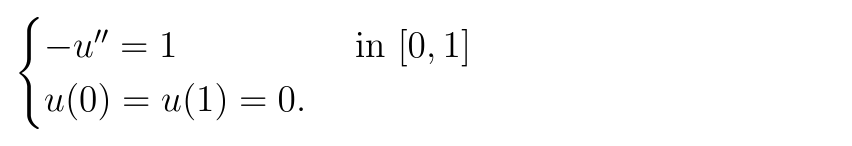

### JAX

In [86]:
x_np = jnp.linspace(0, 1, 100)

In [87]:
f = -jnp.ones(100)

In [88]:
M = jnp.zeros((len(x_np)-2,len(x_np)-2))

In [89]:
for i in range(len(M)):
    M = M.at[i,i].set(-2)
for i in range(len(M)-1):
    M = M.at[i,i+1].set(1)
for i in range(1,len(M)):
    M = M.at[i,i-1].set(1)

In [90]:
M

Array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]], dtype=float64)

In [91]:
f = jnp.reshape(f[1:len(f)-1],(-1,1))*(1/99)**2

In [92]:
u = jnp.matmul(jnp.linalg.inv(M),f)

In [93]:
u = jnp.insert(u,0,0)

In [94]:
u = jnp.insert(u,99,0)

In [95]:
u

Array([0.        , 0.00499949, 0.00989695, 0.01469238, 0.01938578,
       0.02397715, 0.02846648, 0.03285379, 0.03713907, 0.04132231,
       0.04540353, 0.04938272, 0.05325987, 0.057035  , 0.06070809,
       0.06427916, 0.06774819, 0.07111519, 0.07438017, 0.07754311,
       0.08060402, 0.0835629 , 0.08641975, 0.08917457, 0.09182736,
       0.09437812, 0.09682685, 0.09917355, 0.10141822, 0.10356086,
       0.10560147, 0.10754005, 0.10937659, 0.11111111, 0.1127436 ,
       0.11427405, 0.11570248, 0.11702887, 0.11825324, 0.11937557,
       0.12039588, 0.12131415, 0.12213039, 0.12284461, 0.12345679,
       0.12396694, 0.12437506, 0.12468115, 0.12488522, 0.12498725,
       0.12498725, 0.12488522, 0.12468115, 0.12437506, 0.12396694,
       0.12345679, 0.12284461, 0.12213039, 0.12131415, 0.12039588,
       0.11937557, 0.11825324, 0.11702887, 0.11570248, 0.11427405,
       0.1127436 , 0.11111111, 0.10937659, 0.10754005, 0.10560147,
       0.10356086, 0.10141822, 0.09917355, 0.09682685, 0.09437

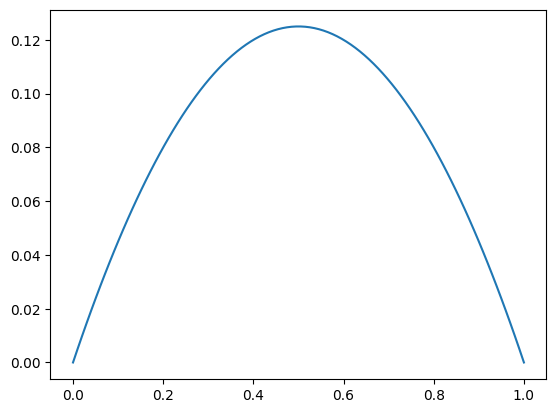

In [96]:
plt.plot(x_np,u)

### PhiFlow

In [74]:
M = tensor(M,channel('b_vec'),dual('x_vec'))
f = tensor(f,channel('b_vec'),dual('row'))
x0 = tensor(f,channel('x_vec'),dual('row'))
u = math.solve_linear(M, f, Solve(x0=x0))

In [97]:
u_spatial = tensor(u,spatial('x'))

In [107]:
u_phi = CenteredGrid(u_spatial,extrapolation.ZERO,x=100, bounds=Box(x=1))

<Figure size 1200x500 with 1 Axes>

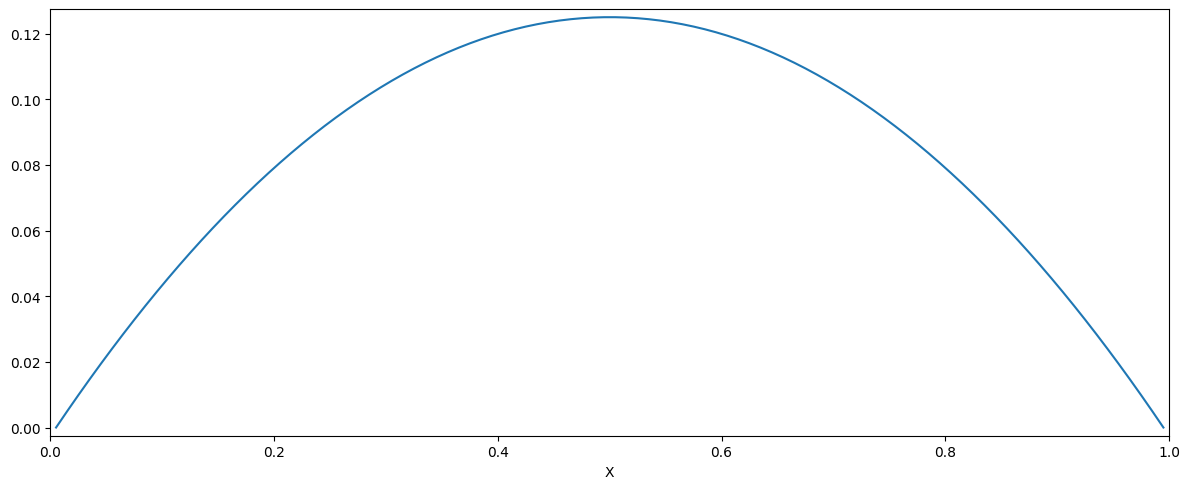

In [108]:
plot(u_phi)

<Figure size 1200x500 with 1 Axes>

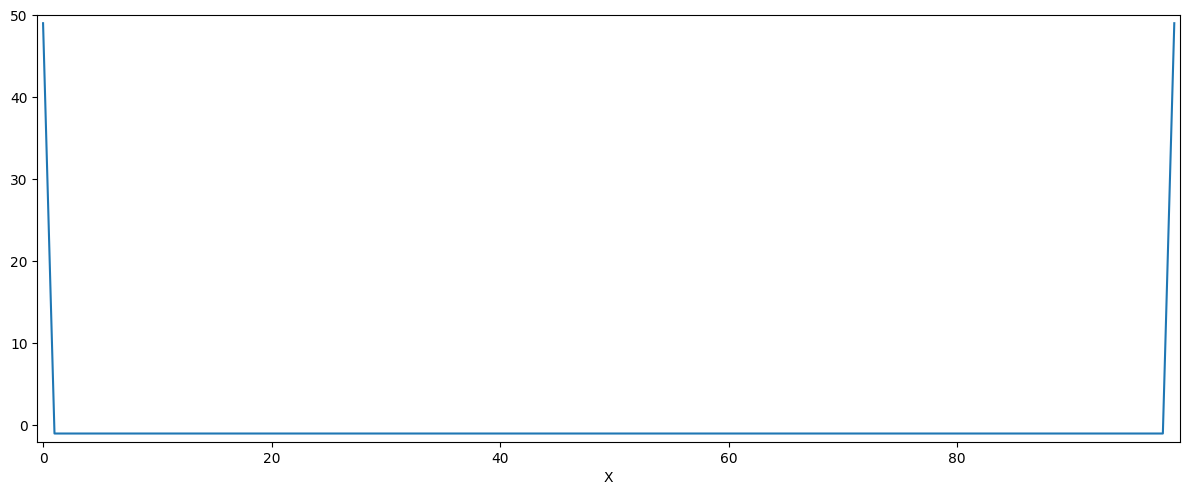

In [109]:
plot(math.laplace(u_spatial,dx=1/99))

In [ ]:
math.laplace(u_spatial,dx=1/99).x[0]

49.0

### PhiFlow

In [ ]:
f = -jnp.ones(100)

In [ ]:
f = f.reshape(100,1)

In [ ]:
f_phi = wrap(f[1:99],channel('row','col'))

In [ ]:
M = jnp.zeros((len(x_np)-2,len(x_np)-2))

In [ ]:
for i in range(len(M)):
    M = M.at[i,i].set(-2)
for i in range(len(M)-1):
    M = M.at[i,i+1].set(1)
for i in range(1,len(M)):
    M = M.at[i,i-1].set(1)

In [ ]:
M_phi = wrap(M,channel('row','col'))

In [ ]:
u_phi = math.dot(M_phi,'col',f_phi,'row')

In [ ]:
u_phi.row[93]

(0.000) along colᶜ

<Figure size 1200x500 with 1 Axes>

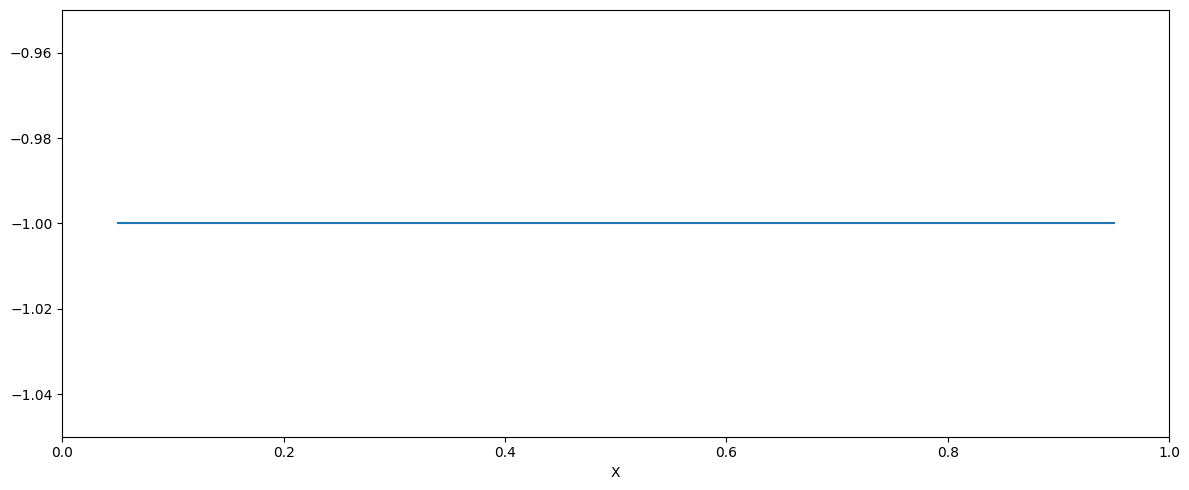

In [ ]:
f = CenteredGrid(-1, x=10, bounds=Box(x=[0,1])) 
plot(f)

In [ ]:
f.shape

(xˢ=10)

In [ ]:
M = jnp.zeros((len(x_np)-2,len(x_np)-2))

In [ ]:
for i in range(len(M)):
    M = M.at[i,i].set(-2)
for i in range(len(M)-1):
    M = M.at[i,i+1].set(1)
for i in range(1,len(M)):
    M = M.at[i,i-1].set(1)

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/jax/lib/python3.9/site-packages/phi/vis/_matplotlib/_matplotlib_plots.py:72: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axis.set_ylim(y_range)
/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/jax/lib/python3.9/site-packages/phi/vis/_matplotlib/_matplotlib_plots.py:223: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  subplot.set_ylim((min_val - .02 * (max_val - min_val), max_val + .02 * (max_val - min_val)))


<Figure size 1200x500 with 1 Axes>

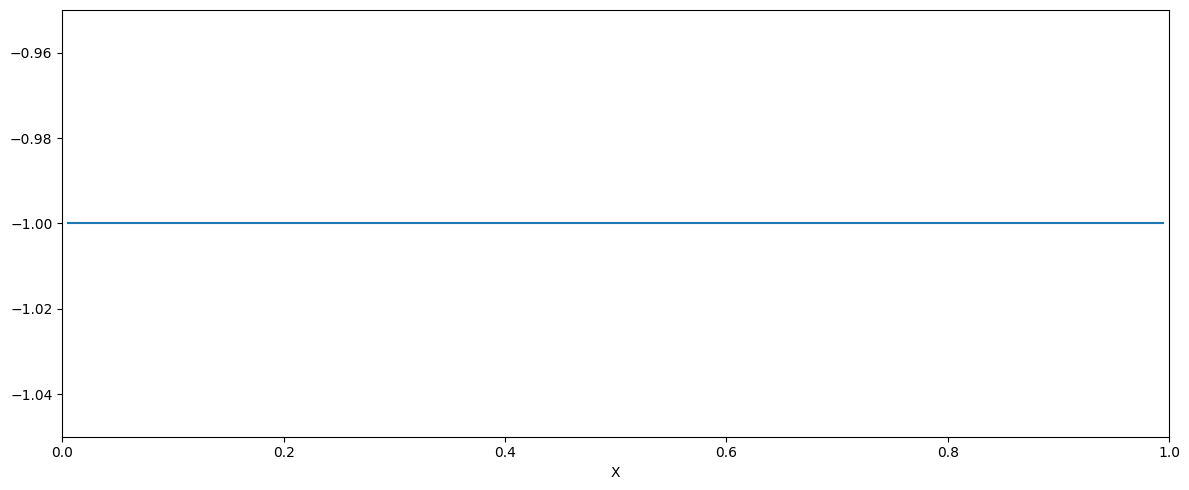

In [ ]:
f = CenteredGrid(-1, extrapolation.BOUNDARY, x=100, bounds=Box(x=1))
plot(f)

In [ ]:
f.values 

(xˢ=100) const -1.0

In [ ]:
f.values[1:99]

(xˢ=98) const -1.0

In [ ]:
M = jnp.zeros((len(x_np)-2,len(x_np)-2))

In [ ]:
for i in range(len(M)):
    M = M.at[i,i].set(-2)
for i in range(len(M)-1):
    M = M.at[i,i+1].set(1)
for i in range(1,len(M)):
    M = M.at[i,i-1].set(1)

In [ ]:
M_phi = wrap(M,channel('row'),dual('col'))

In [ ]:
M_phi.shape

(rowᶜ=98, ~colᵈ=98)

In [ ]:
math.dot(M_phi,'col',f.values[1:99],'x')

AssertionError: Cannot compute dot product between dimensions () on (rowᶜ=98, ~colᵈ=98) and (xˢ=98) on (xˢ=98)

In [ ]:
M_phi ** (-1) * f.values[1:99]

(~colᵈ=98, xˢ=98, rowᶜ=98) -0.497 ± nan (-1e+00...5e-01)

## 2D poisson

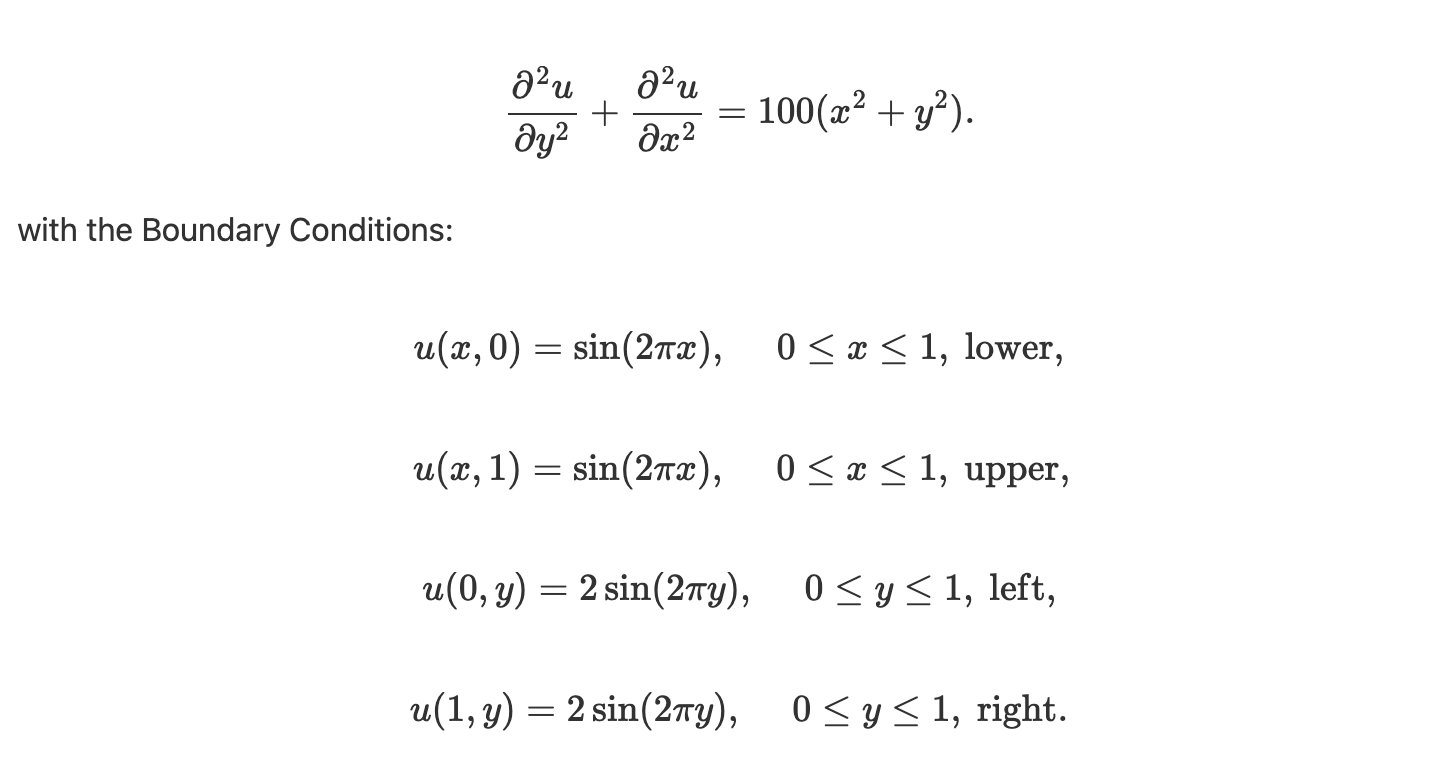

https://john-s-butler-dit.github.io/NumericalAnalysisBook/Chapter%2009%20-%20Elliptic%20Equations/903_Poisson%20Equation-Boundary.html

### JAX

In [ ]:
N=10
h=1/N
x_np=jnp.arange(0,1.0001,h)
y_np=jnp.arange(0,1.0001,h)

In [ ]:
u = jnp.zeros((N+1,N+1))

for i in range(N):
    u = u.at[i,0].set(jnp.sin(2*jnp.pi*x_np[i])) #left 
    u = u.at[i,N].set(jnp.sin(2*jnp.pi*x_np[i])) # right
    
for j in range(N):
    u = u.at[0,j].set(2*np.sin(2*jnp.pi*y_np[j])) #Lower 
    u = u.at[N,j].set(2*np.sin(2*jnp.pi*y_np[j])) #Upper

In [ ]:
X, Y = jnp.meshgrid(x_np, y_np)

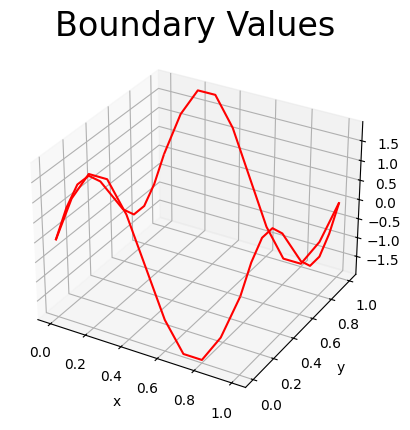

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
ax.plot_wireframe(X, Y, u, color='r', rstride=10, cstride=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.title(r'Boundary Values',fontsize=24,y=1.08)
plt.show()

In [ ]:
N2=(N-1)*(N-1)
A=jnp.zeros((N2,N2))
## Diagonal            
for i in range (0,N-1):
    for j in range (0,N-1):           
        A = A.at[i+(N-1)*j,i+(N-1)*j].set(-4)

# LOWER DIAGONAL        
for i in range (1,N-1):
    for j in range (0,N-1):           
        A = A.at[i+(N-1)*j,i+(N-1)*j-1].set(1)   
# UPPPER DIAGONAL        
for i in range (0,N-2):
    for j in range (0,N-1):           
        A = A.at[i+(N-1)*j,i+(N-1)*j+1].set(1)   

# LOWER IDENTITY MATRIX
for i in range (0,N-1):
    for j in range (1,N-1):           
        A = A.at[i+(N-1)*j,i+(N-1)*(j-1)].set(1)        
        
        
# UPPER IDENTITY MATRIX
for i in range (0,N-1):
    for j in range (0,N-2):           
        A= A.at[i+(N-1)*j,i+(N-1)*(j+1)].set(1)
        
Ainv=jnp.linalg.inv(A)

In [ ]:
r=jnp.zeros(N2)

# vector r      
for i in range(N-1):
    for j in range(N-1):           
        r = r.at[i+(N-1)*j].set(100*h*h*(x_np[i+1]*x_np[i+1]+y_np[j+1]*y_np[j+1]))     
# Boundary        
b_bottom_top=jnp.zeros(N2)
for i in range(N-1):
    b_bottom_top = b_bottom_top.at[i].set(jnp.sin(2*np.pi*x_np[i+1])) #Bottom Boundary
    b_bottom_top = b_bottom_top.at[i+(N-1)*(N-2)].set(jnp.sin(2*np.pi*x_np[i+1]))# Top Boundary
      
b_left_right=jnp.zeros(N2)
for j in range (0,N-1):
    b_left_right = b_left_right.at[(N-1)*j].set(2*np.sin(2*np.pi*y_np[j+1])) # Left Boundary
    b_left_right = b_left_right.at[N-2+(N-1)*j].set(2*np.sin(2*np.pi*y_np[j+1]))# Right Boundary
    
b=b_left_right+b_bottom_top

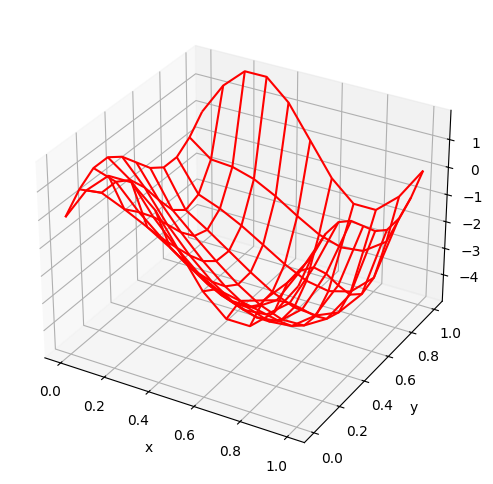

In [ ]:
C=np.dot(Ainv,r-b)
u = u.at[1:N,1:N].set(C.reshape((N-1,N-1)))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, u, color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.show()

### PhiFlow

<Figure size 1200x500 with 2 Axes>

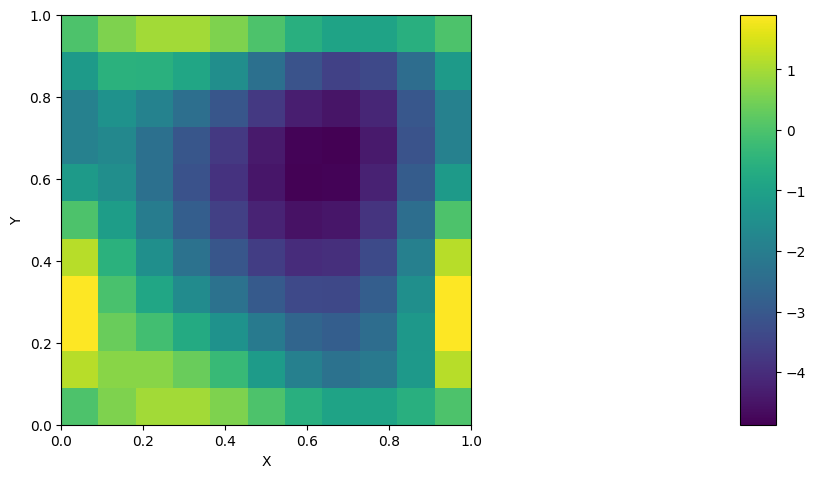

In [ ]:
plot(CenteredGrid(tensor(u,spatial('x,y')),x=11,y=11,bounds=Box(x=1,y=1)))

In [ ]:
u_phi = CenteredGrid(tensor(u,spatial('x,y')),x=11,y=11,bounds=Box(x=1,y=1))

In [ ]:
math.laplace(tensor(u,spatial('x,y')))

(xˢ=11, yˢ=11) -7.88e-09 ± 1.3e+00 (-4e+00...2e+00)

<Figure size 1200x500 with 2 Axes>

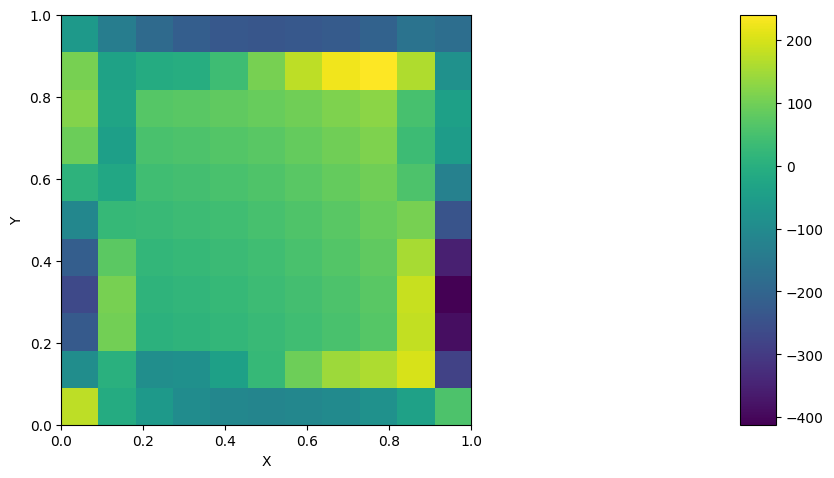

In [ ]:
plot(CenteredGrid(math.laplace(tensor(u,spatial('x,y')),dx=(1/10,1/10)),x=11,y=11,bounds=Box(x=1,y=1)))